In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('../data/seattle_sample_3k.csv')

In [3]:
data = gpd.GeoDataFrame(data, crs="EPSG:32610", geometry=gpd.points_from_xy(x=data.UTM_X, y=data.UTM_Y))

In [4]:
data = data.to_crs(4326)

In [5]:
data['lon'] = data['geometry'].get_coordinates()['x']

In [6]:
data['lat'] = data['geometry'].get_coordinates()['y']

In [7]:
data['price'] = np.power(10, data['log_price']) / 10000

In [8]:
y = data.price
X = data[['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'condition', 'waterfront', 'view', 'age', 'lon', 'lat']]
loc = data[['lon', 'lat']]

In [9]:
X_train, X_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(X, y, loc, train_size=0.8, random_state=42)

In [10]:
X_calib, X_test, y_calib, y_test, loc_calib, loc_test = train_test_split(X_temp, y_temp, loc_temp, train_size=0.5, random_state=42)

In [11]:
model = xgb.XGBRegressor(n_estimators=500, max_depth=3, min_child_weight=1.0, colsample_bytree=1.0)

In [12]:
model.fit(X_train.values, y_train.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
model.score(X_test.values, y_test.values)

0.8678628554694814

In [14]:
feature_names = X_train.columns

In [15]:
explainer = GeoConformalizedExplainer(prediction_f=model.predict,
                                      x_train=X_train,
                                      x_calib=X_calib,
                                      coord_calib=loc_calib.values,
                                      miscoverage_level=0.1,
                                      band_width=0.2,
                                      feature_names=feature_names)

In [16]:
results = explainer.uncertainty_aware_explain(x_test=X_test, coord_test=loc_test)

Training SHAP


 33%|███▎      | 798/2400 [04:35<09:12,  2.90it/s]


KeyboardInterrupt: 

In [17]:
results.accuracy_summary()

,coverage_probability,R2,RMSE,SHAP_Var,Pred_SHAP_Var
bathrooms,0.896667,-1.764631,3.520603,4.483291,17.327145
sqft_living,0.570000,-1.665888,15.554518,90.755139,320.392914
sqft_lot,0.916667,0.503360,3.202120,20.645870,22.553972
grade,0.853333,-0.382213,12.211014,107.876885,414.335297
condition,0.966667,0.455262,1.220742,2.735647,3.746064
waterfront,0.713333,0.921455,1.387158,24.498211,33.191917
view,0.843333,0.839523,2.177057,29.534360,26.722296
age,0.790000,-0.170901,3.446683,10.145709,15.380786
lon,0.893333,0.279597,3.566973,17.661366,17.306246
lat,0.796667,0.850988,6.024061,243.532290,370.987274


In [18]:
# results.accuracy_summary().to_csv('./SeattleHomeSale_accuracy_summary.csv')

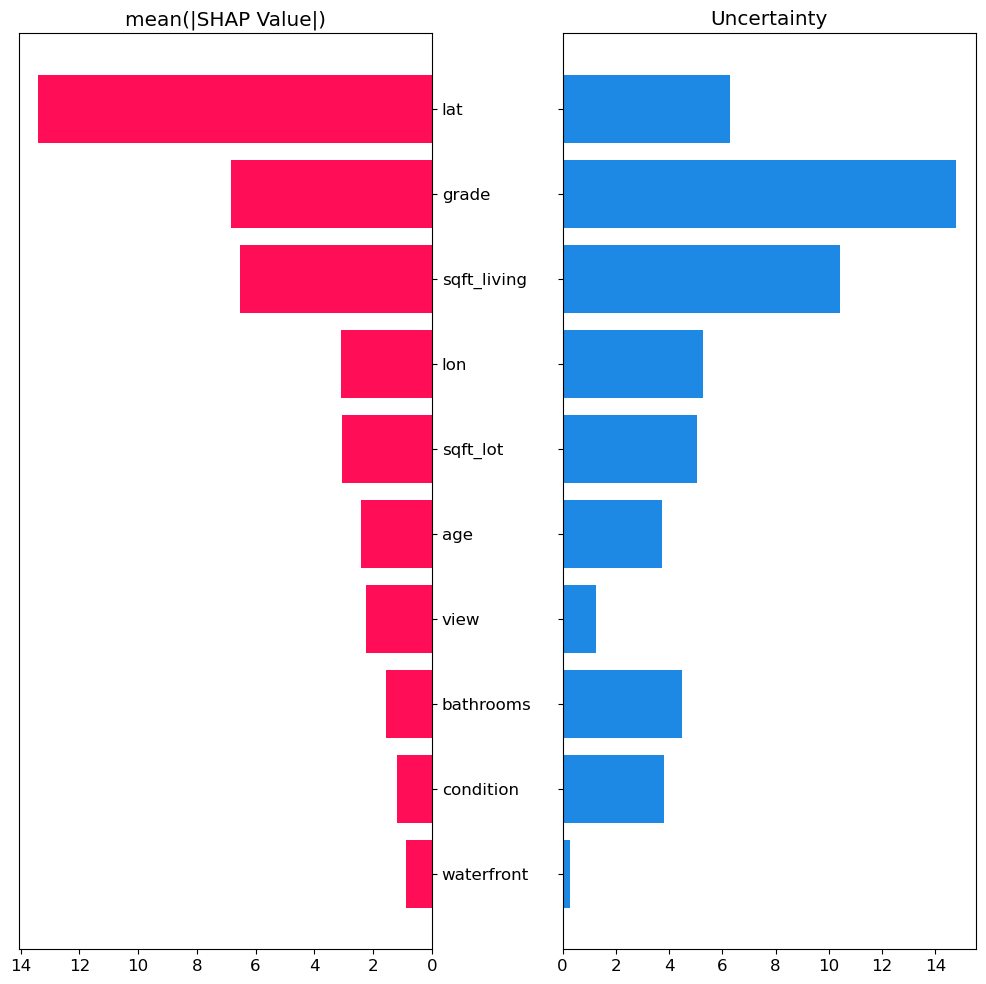

In [19]:
results.plot_absolute_shap_value_with_uncertainty()

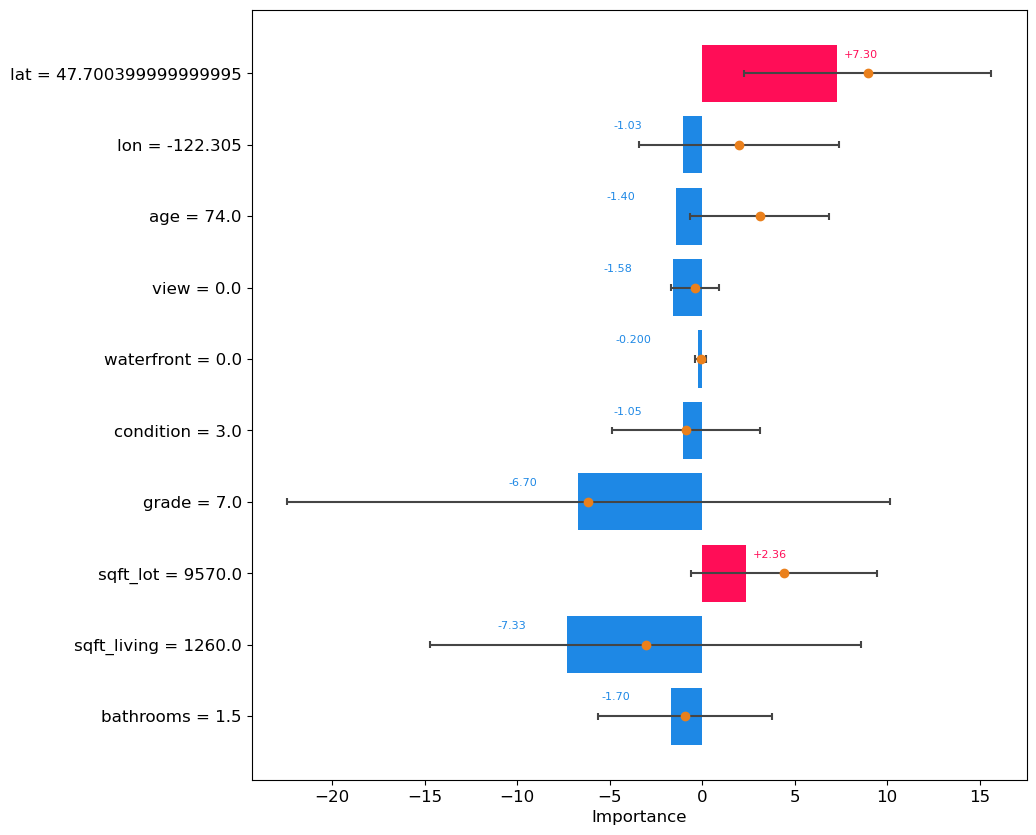

In [20]:
results.plot_shap_values_with_uncertainty(20)

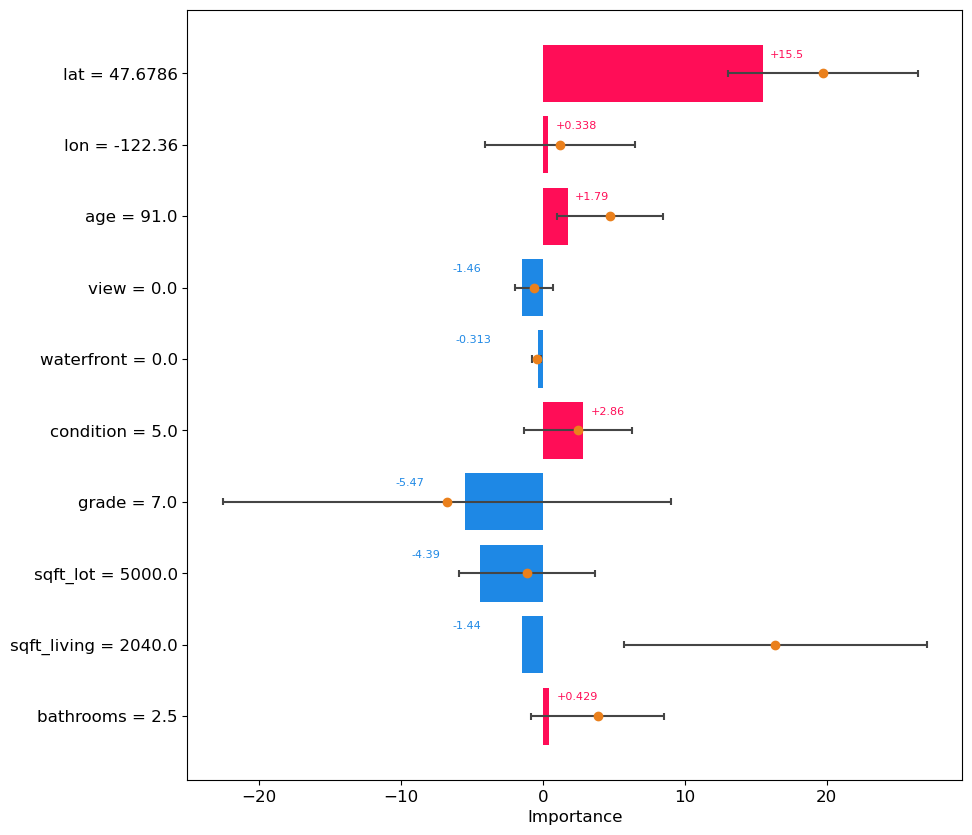

In [21]:
results.plot_shap_values_with_uncertainty(40)

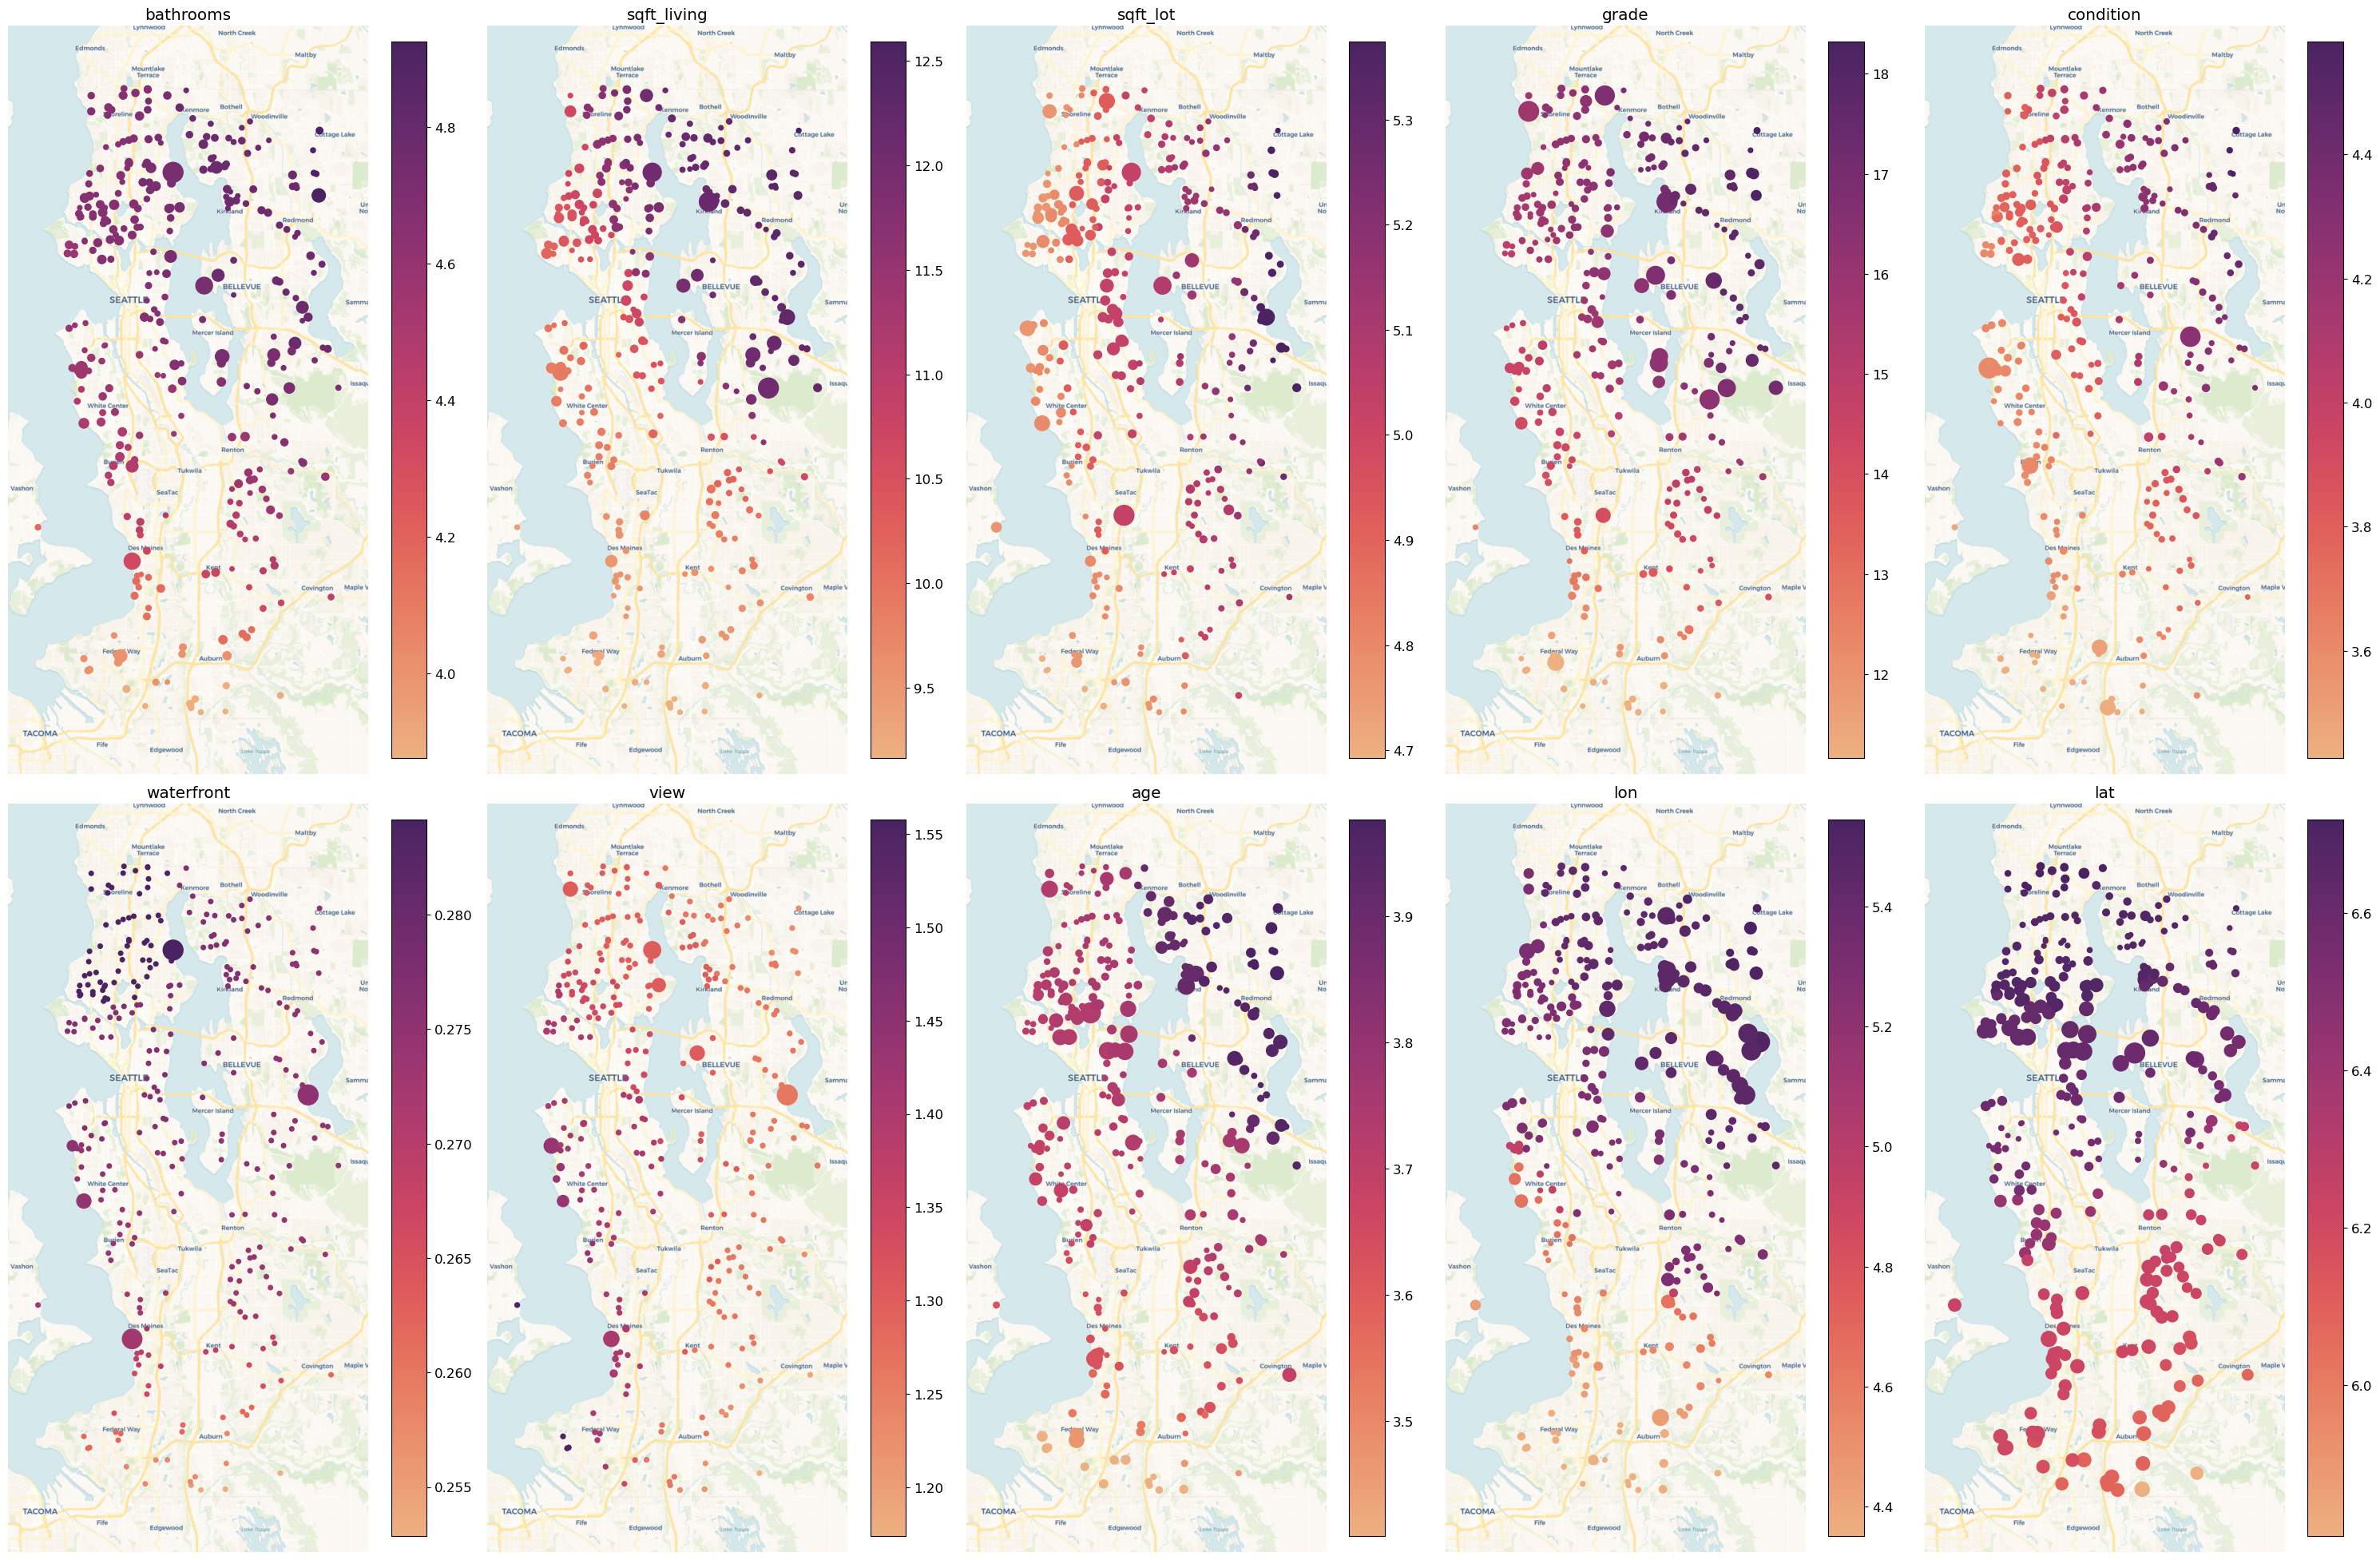

In [22]:
results.plot_geo_uncertainty(figsize=[30, 40], shrink=0.3, s_limits=(4, 18), cmap='flare')

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

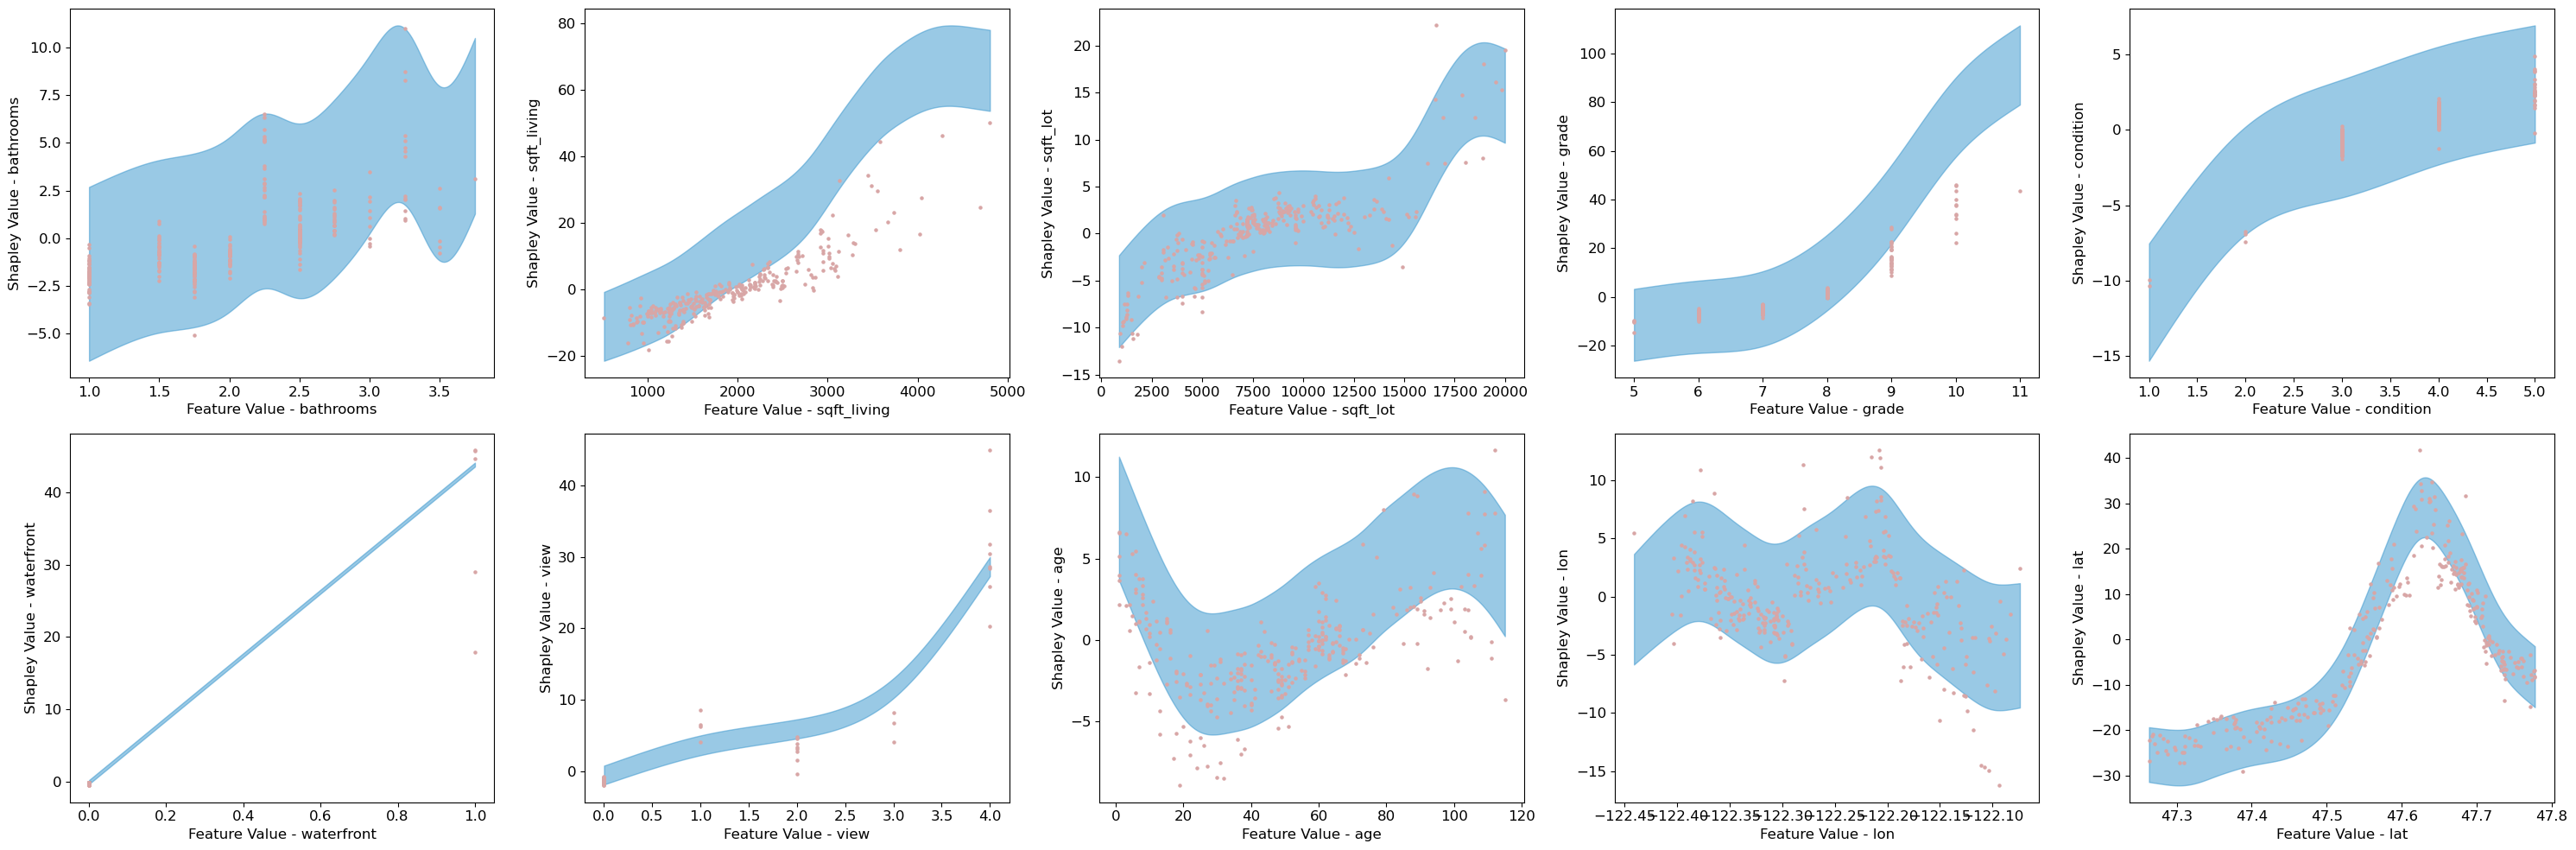

In [23]:
results.plot_partial_dependence_with_fitted_bounds(figsize=[30, 10])

## Bootstrapping

In [24]:
from fastshap import KernelExplainer
from sklearn.utils import resample

In [25]:
n_bootstrap = 2000

In [26]:
n, k = X_test.shape

In [27]:
bootstrap_predictions = np.zeros((n_bootstrap, n, k))

In [ ]:
for i in range(n_bootstrap):
    X_resample, y_resample = resample(X_train, y_train, replace=True, random_state=i)
    model = xgb.XGBRegressor(n_estimators=500, max_depth=3, min_child_weight=1.0, colsample_bytree=1.0)
    model.fit(X_resample, y_resample)
    batch_size = X_test.shape[0] // 2
    explainer = KernelExplainer(model.predict, X_test)
    explainer.stratify_background_set(10)
    explanation_result = explainer.calculate_shap_values(X_test, verbose=True, outer_batch_size=batch_size, inner_batch_size=batch_size, background_fold_to_use=0)[:, :k]
    bootstrap_predictions[i, :, :] = explanation_result

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:184: RuntimeWarning: overflow encountered in cast
  ).astype(
C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:244: RuntimeWarning: overflow encountered in cast
  ).astype(self.return_type)


Number of coalitions to run per sample: 350
Starting Samples 0 - 149
Coalition Size: 1 - Model Evaluations: 21
Coalition Size: 2 - Model Evaluations: 91
Coalition Size: 3 - Model Evaluations: 241
Starting Samples 150 - 299
Coalition Size: 1 - Model Evaluations: 21


C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:244: RuntimeWarning: overflow encountered in cast
  ).astype(self.return_type)


Coalition Size: 2 - Model Evaluations: 91
Coalition Size: 3 - Model Evaluations: 241


C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:184: RuntimeWarning: overflow encountered in cast
  ).astype(
C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:244: RuntimeWarning: overflow encountered in cast
  ).astype(self.return_type)
C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:244: RuntimeWarning: invalid value encountered in cast
  ).astype(self.return_type)


Number of coalitions to run per sample: 350
Starting Samples 0 - 149
Coalition Size: 1 - Model Evaluations: 21
Coalition Size: 2 - Model Evaluations: 91
Coalition Size: 3 - Model Evaluations: 241
Starting Samples 150 - 299
Coalition Size: 1 - Model Evaluations: 21


C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:244: RuntimeWarning: overflow encountered in cast
  ).astype(self.return_type)


Coalition Size: 2 - Model Evaluations: 91
Coalition Size: 3 - Model Evaluations: 241


C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:184: RuntimeWarning: overflow encountered in cast
  ).astype(
C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:244: RuntimeWarning: overflow encountered in cast
  ).astype(self.return_type)


Number of coalitions to run per sample: 350
Starting Samples 0 - 149
Coalition Size: 1 - Model Evaluations: 21
Coalition Size: 2 - Model Evaluations: 91
Coalition Size: 3 - Model Evaluations: 241
Starting Samples 150 - 299
Coalition Size: 1 - Model Evaluations: 21
Coalition Size: 2 - Model Evaluations: 91
Coalition Size: 3 - Model Evaluations: 241


C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:184: RuntimeWarning: overflow encountered in cast
  ).astype(
C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:244: RuntimeWarning: overflow encountered in cast
  ).astype(self.return_type)
C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:244: RuntimeWarning: invalid value encountered in cast
  ).astype(self.return_type)


Number of coalitions to run per sample: 350
Starting Samples 0 - 149
Coalition Size: 1 - Model Evaluations: 21
Coalition Size: 2 - Model Evaluations: 91
Coalition Size: 3 - Model Evaluations: 241
Starting Samples 150 - 299
Coalition Size: 1 - Model Evaluations: 21
Coalition Size: 2 - Model Evaluations: 91
Coalition Size: 3 - Model Evaluations: 241


C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:184: RuntimeWarning: overflow encountered in cast
  ).astype(
C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:244: RuntimeWarning: overflow encountered in cast
  ).astype(self.return_type)
C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:244: RuntimeWarning: invalid value encountered in cast
  ).astype(self.return_type)


Number of coalitions to run per sample: 350
Starting Samples 0 - 149
Coalition Size: 1 - Model Evaluations: 21
Coalition Size: 2 - Model Evaluations: 91
Coalition Size: 3 - Model Evaluations: 241
Starting Samples 150 - 299
Coalition Size: 1 - Model Evaluations: 21
Coalition Size: 2 - Model Evaluations: 91
Coalition Size: 3 - Model Evaluations: 241


C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:184: RuntimeWarning: overflow encountered in cast
  ).astype(
C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:244: RuntimeWarning: overflow encountered in cast
  ).astype(self.return_type)


Number of coalitions to run per sample: 350
Starting Samples 0 - 149
Coalition Size: 1 - Model Evaluations: 21
Coalition Size: 2 - Model Evaluations: 91


In [ ]:
lower_bounds = np.quantile(bootstrap_predictions, q=0.05, axis=0)

In [ ]:
upper_bounds = np.quantile(bootstrap_predictions, q=0.95, axis=0)